## Estrimating the dark matter density profile of a galaxy
Within this part we will be crawling the uniform density sphere model of dark matter, to find the sensitivity and optimized values of $r_0$ and $p_0$. This model estimates the given velocity of a object in the galaxy using the equation beneath:

$\rho(r) = \begin{cases} 
\rho_0, & \text{if } r < r_0 \\
0, & \text{otherwise}
\end{cases}$

$M_{\text{in}}(r) = \int_0^r 4\pi \rho(r') r'^2 \, dr'$

$v(r) = \sqrt{\frac{GM_{\text{in}}(r)}{r}}$

Importing out data and getting it into a useable format

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import seaborn as sns

planets = pd.read_csv('planets_rot.csv')
planets = planets[1:-1]

#Converts the imported data into floats to make them usable 
planets['km/s'] = planets['km/s'].str.replace(r'\[|\]', '').astype(float)
planets['km'] = planets['km'].str.replace(r'\[|\]', '').astype(float)
planets['km/s.1'] = planets['km/s.1'].str.replace(r'\[|\]', '').astype(float)

Defining our model

In [40]:
def density_profile(r, po0, ro0):
    if r < ro0:
        return po0
    else:
        return 0

def M1n(r, po0, ro0):
    lst = []
    integrand = lambda r_prime: 4 * np.pi * density_profile(r_prime, po0, ro0) * (r_prime**2)
    for r1 in r:
        
        result, _ = quad(integrand, 1E-6, r1)
        lst.append(result)
    
    return np.array(lst)

def velocity(r, po0, ro0, G: int = 6.6743e-11):
    M = M1n(r, po0, ro0)
    return np.sqrt(G * M / r)


Now we are going to define a functions that will be used in our MCMC emsemble. The Likelyhood function is used to determine how "good" a proposed step is. The prior function is used to make sure that the walkers do not move in a direction that is not realistic, we want it to explore the correct space. the pdf function uses both the prior and the likelyhood function to determine where the walker should move. 

In [41]:
def ln_prior(params):
   
    po0, ro0 = params
    if po0 > 0 and ro0 > 0:
        return 0
    return -np.inf

def ln_likelihood(params, r, v_obs, v_err):
    po0, ro0 = params
    v_model_predicted = velocity(r, po0, ro0)
    return -0.5 * np.sum((((v_obs - v_model_predicted) **2) / v_err)**2)

def ln_pdf(params, r, v_obs, v_err):
    p = ln_prior(params)
    if p == -np.inf:
        return -np.inf
    return p + ln_likelihood(params, r, v_obs, v_err)

Now we are ready to run our MCMC emsemble. We set a few hyperparameters(number of walkers, dimensions and steps) and then run the emsemble. 

In [42]:
import warnings
warnings.filterwarnings('ignore')

nwalkers = 30  # Number of walkers
ndim = 2
nsteps = 4000
initial_positions = np.random.rand(nwalkers, ndim)  # Random initial positions for the walkers

# Run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_pdf, args=(planets['km'], planets['km/s'], planets['km/s.1']))

sampler.run_mcmc(initial_positions, nsteps)

# Get the chain of samples
samples = sampler.get_chain()


Now we look at the results of our walkers steps and see if they all burn in to about the same range of values. We can see that they do so we can move onto aggregating and interpreting the results. 

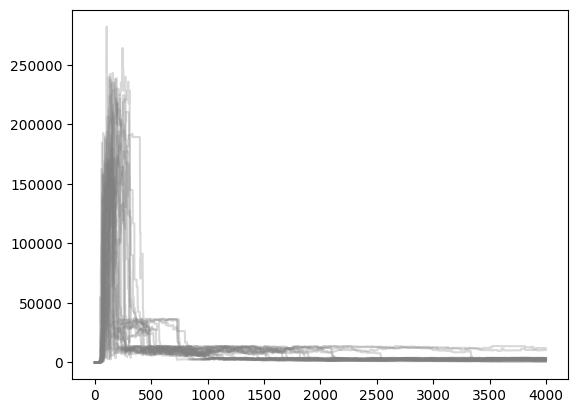

In [43]:
plt.plot(samples[:, :, 0],color='Grey', alpha=0.3)
samples2 = samples[2500:, :, :]

Now that we have removed the burn in period we can plot the data to see the range they converged into. We can see that the $p_0$ range is from $1500$ to $4000$ and the $r_0$ range is from $0.5\text{e}6$ to $0.8\text{e}6$. This tells us the range of values that are most likely to be the true values of $p_0$ and $r_0$ given that the model we are using is correct.

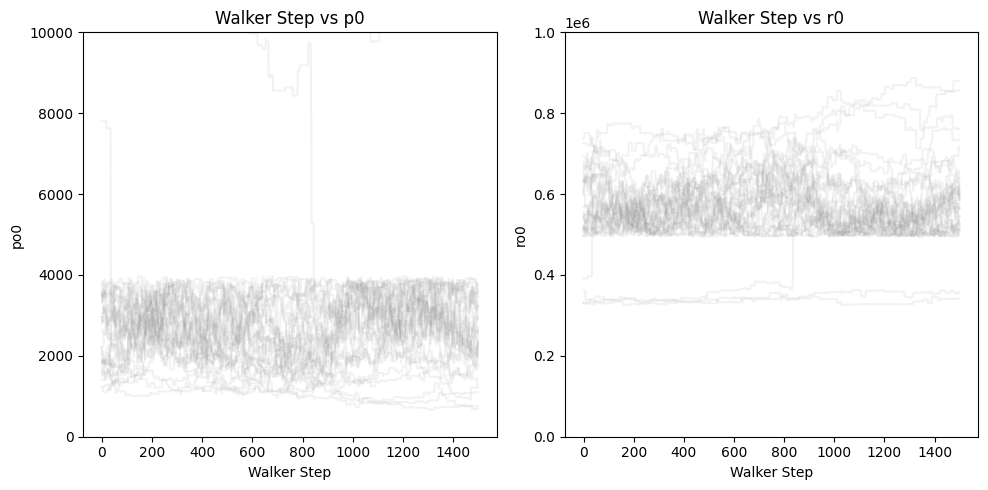

In [44]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(samples2[:, :, 0], color='gray', alpha=0.1)
plt.title('Walker Step vs p0')
plt.ylabel('po0')
plt.xlabel('Walker Step')
plt.ylim(0, 1E4)

plt.subplot(1, 2, 2)
plt.plot(samples2[:, :, 1], color='gray', alpha=0.1)
plt.title('Walker Step vs r0')
plt.ylabel('ro0')
plt.xlabel('Walker Step')
plt.ylim(0, 1E6)

plt.tight_layout()
plt.show()


Now we can plot the data using a KDE plot the see the range of $p_0$ and $r_0$ values that are most likely to be the true values. The little splotches off to the side are the walkers that have not yet burned in. These represent the range of values that are most likely to be the true values of $p_0$ and $r_0$ given that the model we are using is correct. But if you look into the next part of this project you will see that the model we are using is not correct, and then in part 3 we will be using a more complex model to estimate the dark matter density profile of a galaxy.

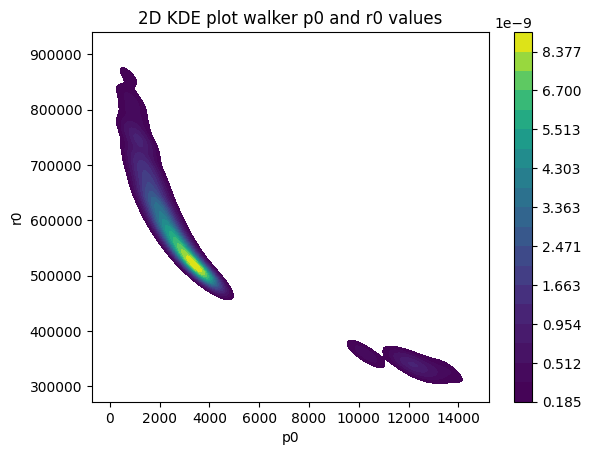

In [45]:
# plot a 2dkde plot of p0 and ro0
sample_x = samples2[:, :, 0].flatten()
sample_y = samples2[:, :, 1].flatten()
sns.kdeplot(x=sample_x, y=sample_y, fill=True, cmap='viridis',cbar=True,levels=20)
plt.xlabel('p0')
plt.ylabel('r0')
plt.title('2D KDE plot walker p0 and r0 values')
plt.show()
 